<a href="https://colab.research.google.com/github/silverstar0727/Graph-Neural-Networks/blob/main/Labs/Colab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS224W - Colab 1**

이번 랩에서는 노드 임베딩을 학습하기 위한 전체 파이프라인을 다룬다. 이때 아래의 3가지 과정을 거친다.

1. 시작하기 앞서 지난 랩에서 사용한 데이터 셋을 load한다.  [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)
2. 멀티 그래프의 통계를 확인하고, 이 그래프를 Pytorch tensor로 변환한다. 
3. 최종적으로 노드 임베딩 모델에 대한 알고리즘을 통해 훈련을 진행한다. 단순하게 구현하기 위해서 여기서 사용한 모델은 강의에서 다룬 Deepwalk와 node2vec보다 단순화되었다. 그러나, 여전히 이것은 도전적인 구현이며, 이러한 과정에서 파이토치를 사용한다..

# 1 Graph Basics

데이터를 로드하고 통계를 확인해보기

## Setup
지난 랩보다 더 구체적으로 NetworkX를 다룰 예정이다

In [21]:
import networkx as nx

## Zachary's karate club network

가라데 동아리 네트워크 데이터는 회원 34명의 클럽 외적인 상호작용의 링크에 대한 사회적 네트워크를 가진 그래프이다.

In [22]:
G = nx.karate_club_graph()

# G는 무방향 그래프이다.
type(G)

networkx.classes.graph.Graph

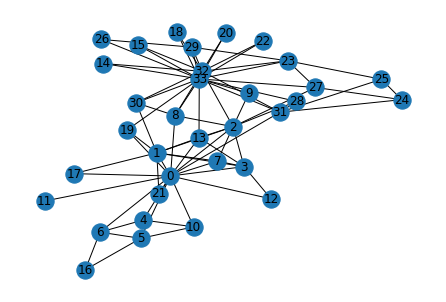

In [23]:
# 그래프를 시작화 해보자.
nx.draw(G, with_labels = True)

## Question 1: 주어진 그래프의 평균 degree는 몇인가? (5 Points)

In [24]:
def average_degree(num_edges, num_nodes):
  # TODO: 정해진 부분만 코딩하여 소숫점 첫째짜리에서 반올림 한 결과가 출력되도록 하기

  avg_degree = 0

  ############# Your code here ############

  avg_degree = (num_edges*2) / num_nodes
  avg_degree = round(avg_degree)
  
  #########################################

  return avg_degree

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = average_degree(num_edges, num_nodes)
print("Average degree of karate club network is {}".format(avg_degree))

Average degree of karate club network is 5


## Question 2: 평균 clustering coefficient는 몇인가? (5 Points)

$$e_v = {이웃 노드들의 Edges  수 \over {k_v \choose 2}}$$

$$Avg(e_v) = {\sum_v^N {e_v \over N}}$$

In [25]:
def average_clustering_coefficient(G):
  # TODO: 소수점 셋째자리에서 반올림한 결과가 출력되도록 코드를 완성하기

  avg_cluster_coef = 0

  ############# Your code here ############
  ## Note: 
  ## 1: NX의 적절한 내장함수를 사용하기

  avg_cluster_coef = round(nx.average_clustering(G), 2)

  #########################################

  return avg_cluster_coef

avg_cluster_coef = average_clustering_coefficient(G)
print("Average clustering coefficient of karate club network is {}".format(avg_cluster_coef))

Average clustering coefficient of karate club network is 0.57


## Question 3: node 0의 pagerank score가 한번의 iteration을 거친 이후에 어떤 값인가? (5 Points) 

$$r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}$$

In [26]:
def one_iter_pagerank(G, beta, r0, node_id):
  # TODO: 소수점 두자리까지 출력

  r1 = 0

  ############# Your code here ############
  ## Note: 
  ## 1: 반드시 nx.pagerank를 사용하세요

  PR = nx.pagerank(G, alpha=beta, max_iter=1, tol=r0)
  r1 = PR[node_id]

  #########################################

  return r1

beta = 0.8
r0 = 1 / G.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G, beta, r0, node)
print("The PageRank value for node 0 after one iteration is {}".format(r1))

The PageRank value for node 0 after one iteration is 0.1281045751633987


## Question 4: node 5의 closeness centrality의 값은 얼마인가? (5 Points)

closeness centrality: $c(v) = \frac{1}{\sum_{u \neq v}\text{shortest path length between } u \text{ and } v}$

In [27]:
def closeness_centrality(G, node=5):
  # TODO: 소수점 두자리까지 그 값을 반환하도록 하자.

  closeness = 0

  ############# Your code here ############
  ## Note:
  ## 1: networkx의 closeness centrality 내장함수를 사용할 수 있다.
  ## 2: 그러나 내장함수는 Normalized된 값을 바로 반환한다. 
  ## 우리가 lecture에서 배운것은 raw(unnormalized) 값이므로 이것을 반환하자.

  n = 0
  for i in G.neighbors(node):
      n += 1

  CC = nx.closeness_centrality(G, u=node)
  CC *= (G.number_of_nodes() - 1) / (n - 1)
  closeness = round(CC, 2)

  #########################################

  return closeness

node = 5
closeness = closeness_centrality(G, node=node)
print("The node 5 has closeness centrality {}".format(closeness))

The node 5 has closeness centrality 4.22


# 2 Graph to Tensor

이제 머신러닝에 사용하기 위해서 그래프를 pytorch 텐서로 변환해보자.

## Setup

In [28]:
import torch
print(torch.__version__)

1.9.0+cu111


## PyTorch tensor basics

파이토치 텐서의 기초 자료들(모두 0, 1, random values)을 만들어보자

In [29]:
# 3 x 4 의 값 1인 텐서
ones = torch.ones(3, 4)
print(ones)

# 3 x 4 크기의 값 0인 텐서
zeros = torch.zeros(3, 4)
print(zeros)

# 3 x 4 크기의 [0, 1) 사이 랜덤한 값을 갖는 텐서
random_tensor = torch.rand(3, 4)
print(random_tensor)

# 텐서의 크기 확인
print(ones.shape)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0.2417, 0.9127, 0.7875, 0.6463],
        [0.1192, 0.1317, 0.9079, 0.4481],
        [0.0022, 0.4382, 0.3800, 0.5075]])
torch.Size([3, 4])


텐서는 단일의 데이터 타입을 dtype 형태로 지정이 가능하다

In [30]:
# 3 x 4 크기의 텐서를 부동소수점 32-bit의 크기로 0의 값을 저장
zeros = torch.zeros(3, 4, dtype=torch.float32)
print(zeros.dtype)

# 64비트의 정수형으로 변환
zeros = zeros.type(torch.long)
print(zeros.dtype)

torch.float32
torch.int64


## Question 5: edge_list를 가라데 동아리 네트워크로부터 얻고, 이를 torch.LongTensor로 변환하여 torch.sum과 pos_edge_index값을 구하기 (10 Points)


In [31]:
def graph_to_edge_list(G):
  # TODO: 두 노드를 잇는 엣지를 튜플의 형태로, 그리고 모든 엣지를 list에 담아서 반환

  edge_list = []

  ############# Your code here ############

  edge_list = list(G.edges)

  #########################################

  return edge_list

def edge_list_to_tensor(edge_list):
  # TODO: edge_list를 tensor로 만드는 함수를 작성하기. 
  # 반환되는 것은 [2 x len(edge_list)] 크기의 텐서여야 함.

  edge_index = torch.tensor([])

  ############# Your code here ############
  
  temp1 = []
  temp2 = []
  for i in range(len(edge_list)):
      a, b = edge_list[i]
      temp1.append(a)
      temp2.append(b)
  
  edge_index = torch.tensor([temp1, temp2])

  #########################################

  return edge_index

pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


## negative edge에 대한 샘플링하는 함수를 구현하기. 그리고 어떤 엣지가 negative일 가능성이 있는지 답하기 (10 Points)

In [38]:
!pip install torch_geometric -q
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html -q
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html -q

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 10.4 MB 1.2 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 3.7 MB 3.5 MB/s 


In [125]:
import random
from torch_geometric.utils import negative_sampling

def sample_negative_edges(G, pos_edge_index, num_neg_samples):
  # TODO: negative edges 리스트를 반환하는 함수를 구현하기.
  # 그 숫자는 num_neg_samples와 같다.
  # corner case(가능한 neg edges가 num_neg_samples보다 큰 경우)는 고려하지 않아도 됨.
  # self loop는 positive나 negative일 수 없고, (0, 1)이 pos edge라면, (1, 0)은 neg edge이 될 수 없음.
  
  neg_edge_list = []

  ############# Your code here ############

  neg_edge_index = negative_sampling(
    edge_index=pos_edge_index, #positive edges
    num_nodes=G.number_of_nodes(), # number of nodes
    num_neg_samples=len(pos_edge_list)) # number of neg_sample equal to number of pos_edges

  #########################################

  #return neg_edge_list
  return neg_edge_index

# Sample 78 negative edges
#neg_edge_list = sample_negative_edges(G, pos_edge_index, len(pos_edge_list))

# Transform the negative edge list to tensor
#neg_edge_index = edge_list_to_tensor(neg_edge_list)
neg_edge_index = sample_negative_edges(G, pos_edge_index, len(pos_edge_list))
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

############# Your code here ############
## Note:
## 1: 5개의 각 노드에 대한 negative edge여부를 출력

#########################################

The neg_edge_index tensor has shape torch.Size([2, 78])


# 3 Node Emebedding Learning

최종적으로 우리는 알고리즘을 이용한 첫 훈련으로 노드 임베딩 모델을 실행하여볼 예정이다.


## Setup

In [126]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(torch.__version__)

1.9.0+cu111


우리의 노드임베딩 훈련을 위해서 nn.Embedding module을 사용할 예정이다.

In [127]:
# 임베딩 레이어를 초기화하자.
# 4개의 임베딩을 생성하고 각 임베딩 벡터 차원은 8이다.

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Sample embedding layer: {}'.format(emb_sample))

Sample embedding layer: Embedding(4, 8)


We can select items from the embedding matrix, by using Tensor indices

In [128]:
# 임베딩된 단일 노드를 확인
id = torch.LongTensor([1])
print(emb_sample(id))

# 임베딩된 여러 노드를 확인
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# 임베딩 행렬을 출력
shape = emb_sample.weight.data.shape
print(shape)

# 가중치를 1로 초기화
emb_sample.weight.data = torch.ones(shape)

# 임베딩이 제대로 초기화 된지 확인하기
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[ 0.0101,  0.8362,  1.2051, -0.0683, -0.4875, -0.4971,  1.4690,  0.0375]],
       grad_fn=<EmbeddingBackward>)
tensor([[ 0.0101,  0.8362,  1.2051, -0.0683, -0.4875, -0.4971,  1.4690,  0.0375],
        [ 0.6357, -0.7775, -0.0557, -0.0443,  2.0859,  0.1051,  0.0199, -0.6802]],
       grad_fn=<EmbeddingBackward>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward>)




이제 노드 임베딩 행렬을 아래의 조건에 맞게 생성해보자.
* 각 노드의 임베딩이 16차원이 되어야 함
* 초기화된 행렬은 uniform 분포로 [0, 1) 사이 값으로 초기화 되어 있어야 함. (torch.rand 이용)

In [129]:
# Please do not change / reset the random seed
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
  # TODO: 임베딩 행렬을 만들어 반환하는 함수를 작성한다.

  emb = None

  ############# Your code here ############

  emb = nn.Embedding(num_embeddings=num_node, embedding_dim=embedding_dim)

  shape = emb.weight.data.shape
  emb.weight.data = torch.rand(shape)

  #########################################

  return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# 임베딩 레이어 출력
print("Embedding: {}".format(emb))

# 노드 0과 3을 얻어서 확인해보기
print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[0.2114, 0.7335, 0.1433, 0.9647, 0.2933, 0.7951, 0.5170, 0.2801, 0.8339,
         0.1185, 0.2355, 0.5599, 0.8966, 0.2858, 0.1955, 0.1808],
        [0.7486, 0.6546, 0.3843, 0.9820, 0.6012, 0.3710, 0.4929, 0.9915, 0.8358,
         0.4629, 0.9902, 0.7196, 0.2338, 0.0450, 0.7906, 0.9689]],
       grad_fn=<EmbeddingBackward>)


## Visualize the initial node embeddings
임베딩 매트릭스를 이해하는 한 가지 좋은 방법은 2D 공간에서 그것을 시각화하는 것이다. 우리는 먼저 임베딩의 차원성을 2D 공간으로 줄이기 위해 PCA를 한다. 그런 다음 우리는 각 점이 속한 community에 의해 색칠된 각 점을 시각화한다.

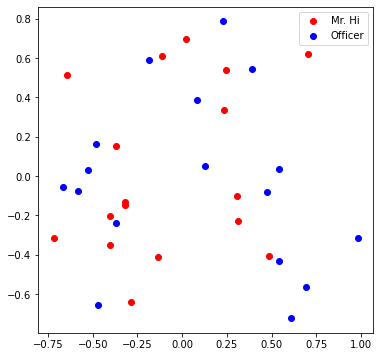

In [130]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

## Question 7: 임베딩 훈련하기 (20 Points)


우리는 모든 엣지를 positive 또는 negative로 분류하는 작업을 위해 임베딩을 최적화하고자 한다. 각 노드에 대한 엣지와 임베딩이 주어지면, 시그모이드 다음에 오는 임베딩의 내적은 우리에게 그 가장자리가 positive(시그모이드 < 0.5의 출력)이거나 negative(시그모이드 < 0.5의 출력)인 예측을 반환한다.

문제가 발생한 경우 질문 1-6에 대한 답변이 올바른지 확인하자.

In [131]:
from torch.optim import SGD
import torch.nn as nn

def accuracy(pred, label):
  # TODO: 정확도 함수 구현하기. 이 함수는 예측과 라벨 텐서를 입력으로 받고,
  # 예측이 0.5가 넘을 경우 라벨을 1로, 아니면 0으로 분류한다.
  # 그 다음 정확도를 소수점 4째자리까지 나타내어 반환하면 된다.

  accu = 0.0

  ############# Your code here ############

  n = len(pred)
  tp = 0
  tn = 0
  for i in range(n):
      if (pred[i] > 0.5):
          if label[i] == 1:
              tp += 1
      else:
          if label[i] == 0:
              tn += 1
    
  accu = (tp + tn) / n
  accu = round(accu, 4)

  #########################################

  return accu

def train(emb, loss_fn, sigmoid, train_label, train_edge):
  # TODO: 임베딩 레이어 훈련하기. epoch, lr을 바꿀 수 있고 아래의 절차를 참고하기
  # (1) train_edge로부터 노드 임베딩 얻기 얻기
  # (2) 임베딩과 각 노드쌍을 내적하기
  # (3) 내적의 결과를 sigmoid에 통과하기
  # (4) sigmoid의 결과를 loss_fn으로 계산하기
  # (5) 모든 로스와 정확도를 각 에폭마다 출력하기
  # (6) 임베딩을 loss와 optimizer로 업데이트 하기

  epochs = 300
  learning_rate = 0.1

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for i in range(epochs):

    ############# Your code here ############
    
    optimizer.zero_grad()

    out = emb(train_edge)
    out = torch.matmul(out[0], out[1].T)[0]
    out = sigmoid(out)

    acc = accuracy(out, train_label)
    loss = loss_fn(out, train_label)

    if i % 10 == 0:
        print(f"epochs: {i}, loss: {loss:.4f}, accuracy: {acc}")

    loss.backward()
    optimizer.step()
    
    #########################################

loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

print(pos_edge_index.shape)

# positive와 negative 라벨 만들기
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# postivie와 negative 라벨을 하나의 텐서로 concat
train_label = torch.cat([pos_label, neg_label], dim=0)

# 네트워크가 너무 작으므로 테스트 데이터셋은 없음
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print(train_edge.shape)

train(emb, loss_fn, sigmoid, train_label, train_edge)

torch.Size([2, 78])
torch.Size([2, 156])
epochs: 0, loss: 1.9176, accuracy: 0.5
epochs: 10, loss: 0.9955, accuracy: 0.4936
epochs: 20, loss: 0.6917, accuracy: 0.5
epochs: 30, loss: 0.5891, accuracy: 0.6923
epochs: 40, loss: 0.5449, accuracy: 0.7436
epochs: 50, loss: 0.5199, accuracy: 0.7436
epochs: 60, loss: 0.5029, accuracy: 0.7436
epochs: 70, loss: 0.4908, accuracy: 0.75
epochs: 80, loss: 0.4828, accuracy: 0.75
epochs: 90, loss: 0.4774, accuracy: 0.75
epochs: 100, loss: 0.4736, accuracy: 0.75
epochs: 110, loss: 0.4705, accuracy: 0.75
epochs: 120, loss: 0.4680, accuracy: 0.75
epochs: 130, loss: 0.4658, accuracy: 0.75
epochs: 140, loss: 0.4640, accuracy: 0.75
epochs: 150, loss: 0.4624, accuracy: 0.75
epochs: 160, loss: 0.4610, accuracy: 0.75
epochs: 170, loss: 0.4597, accuracy: 0.75
epochs: 180, loss: 0.4585, accuracy: 0.75
epochs: 190, loss: 0.4575, accuracy: 0.75
epochs: 200, loss: 0.4565, accuracy: 0.75
epochs: 210, loss: 0.4556, accuracy: 0.75
epochs: 220, loss: 0.4548, accuracy: 0

## Visualize the final node embeddings
Visualize your final embedding here! 
You can visually compare the figure with the previous embedding figure. 
After training, you should oberserve that the two classes are more evidently separated. 
This is a great sanitity check for your implementation as well.

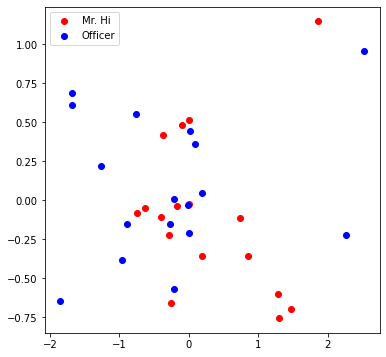

In [132]:
# Visualize the final learned embedding
visualize_emb(emb)